In [1]:
import pandas as pd
df = pd.read_csv("yelp_ml_master.csv")

In [2]:
import numpy as np
import ast
df['hours'] = df['hours'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('{') and x.endswith('}') else x)

In [3]:
df['attributes'] = df['attributes'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('{') and x.endswith('}') else x)

In [4]:
def time_to_minutes(time_str):
    # Split the time string into hours and minutes
    hours, minutes = map(int, time_str.split(':'))
    # Convert hours to minutes and add to minutes
    return hours * 60 + minutes


In [5]:
def get_average_time(row):
    hours = row['hours']
    total_time = []
    for day, hour in hours.items():
        str_list = hour.split('-')
        time = time_to_minutes(str_list[1]) - time_to_minutes(str_list[0])
        if time < 0:
            time = time_to_minutes(str_list[1]) + 24 * 60 - time_to_minutes(str_list[0])
        if time > 0 : total_time.append(time)
    return np.mean(total_time)

In [6]:
df = df.dropna()

In [7]:
df['mean_time'] = df.apply(get_average_time, axis=1)

/Users/sherryyang/anaconda3/envs/cse481/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/sherryyang/anaconda3/envs/cse481/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [8]:
brand_counts = df.groupby(['name']).size().reset_index(name='count')
brand_counts.sort_values('count')

,name,count
0,"""Genuino"" Italian Cafe'",1
19439,Pho Cam Ly,1
19438,Pho Cali Vietnamese Restaurant,1
19436,Pho Cafe Hong Kong Diner,1
19435,Pho Bowl - Palm Harbor,1
...,...,...
28809,Wendy's,304
3681,Burger King,310
24561,Taco Bell,352
24035,Subway,405


In [9]:
df = df.merge(brand_counts, on = 'name')

In [10]:
import pandas as pd
import ast

# Assuming 'df' is your DataFrame and it has a 'stars_y' column for ratings

# Define a function to safely convert stringified lists to actual lists
def string_to_list(string_list):
    try:
        return ast.literal_eval(string_list)
    except ValueError:
        # In case of an error, return an empty list
        return []
    except SyntaxError:
        # Handle strings that are not in list format (e.g., single quotes missing)
        return [string_list.strip("[]").replace("'", "").split(", ")]

# Apply the function to the entire 'categories_list' column
df['categories_list'] = df['categories_list'].apply(string_to_list)

In [11]:

# Now, you can explode the 'categories_list' column
exploded_df = df.explode('categories_list')

# Group by the individual categories and calculate the mean rating and count
category_stats = exploded_df.groupby('categories_list')['stars_y'].agg(['mean', 'count'])

# Convert the Series with multi-level columns to a DataFrame if needed
category_stats_df = category_stats.reset_index()

# Rename columns for clarity
category_stats_df.columns = ['Category', 'AverageRating', 'Count']

In [12]:
category_stats_df = category_stats_df[~category_stats_df['Category'].isin(['Restaurants', 'Restaurants	', 'Food'])]
category_stats_df = category_stats_df[~category_stats_df['Category'].str.strip().isin(['Restaurants', 'Food'])]

In [13]:
category_stats_df = category_stats_df.sort_values('Count')
category_stats_df = category_stats_df.tail(32)

In [14]:
selected_category = list(category_stats_df['Category'])

In [15]:
attribute_set = {}

for attribute in df.attributes:
    if attribute is not None:
        for key, value in attribute.items():
            if key in attribute_set.keys() :
                attribute_set[key].add(value)
            else:
                attribute_set[key] = set()
                attribute_set[key].add(value)

selected_attributes = []
for key, value in attribute_set.items():
    if len(value) <= 3 and 'True' in value:
        selected_attributes.append(key)

In [16]:
selected_attributes 

['RestaurantsDelivery',
 'OutdoorSeating',
 'BusinessAcceptsCreditCards',
 'BikeParking',
 'RestaurantsTakeOut',
 'ByAppointmentOnly',
 'Caters',
 'RestaurantsReservations',
 'GoodForKids',
 'CoatCheck',
 'DogsAllowed',
 'RestaurantsTableService',
 'RestaurantsGoodForGroups',
 'WheelchairAccessible',
 'HasTV',
 'HappyHour',
 'DriveThru',
 'BusinessAcceptsBitcoin',
 'Corkage',
 'GoodForDancing',
 'BYOB',
 'Open24Hours',
 'RestaurantsCounterService',
 'AcceptsInsurance']

In [17]:
import pandas as pd

# Function to process a single row's attribute dictionary
def process_attributes(attr_dict):
    # Initialize the array with -1
    attr_array = [0] * len(selected_attributes)
    if attr_dict is None:
        return attr_array
    
    for i, attr in enumerate(selected_attributes):
        if attr in attr_dict:
            attr_array[i] = 1 if attr_dict[attr] == 'True' else 0
    
    return attr_array

# Apply the function to each row
df['attribute_array'] = df['attributes'].apply(process_attributes)

# Now df['attribute_array'] contains the desired arrays for each row

In [18]:
import pandas as pd

# Function to process a single row's attribute dictionary
def process_attributes(attr_dict):
    # Initialize the array with -1
    attr_array = [0] * len(selected_attributes)
    if attr_dict is None:
        return attr_array
    
    for i, attr in enumerate(selected_attributes):
        if attr in attr_dict:
            attr_array[i] = 1 if attr_dict[attr] == 'True' else 0
    
    return attr_array

# Apply the function to each row
df['attribute_array'] = df['attributes'].apply(process_attributes)

In [19]:
def process_category(c_set):
    # Initialize the array with -1
    attr_array = [0] * len(selected_category)
    if c_set is None:
        return attr_array
    
    for i in range(len(selected_category)):
        if selected_category[i]  in c_set: 
            attr_array[i] = 1
    
    return attr_array

# Apply the function to each row
df['category_array'] = df['categories_list'].apply(process_category)

In [20]:
df.columns

Index(['Unnamed: 0', 'business_id', 'name', 'address', 'city', 'state',
       'postal_code', 'latitude', 'longitude', 'stars_x', 'review_count',
       'is_open', 'attributes', 'categories', 'hours', 'stars_y',
       'categories_list', 'category_counts', 'postal_counts', 'city_counts',
       'state_counts', 'category_postal_counts', 'category_city_counts',
       'category_state_counts', 'Zip', 'population_postal', 'density_postal',
       'City', 'St', 'State', 'CitySt', 'County', 'Country', 'Coordinates',
       'lat', 'long', '_merge', 'population_city', 'density_city',
       'population_state', 'density', 'attribute_array', 'mean_time', 'count',
       'category_array'],
      dtype='object')

In [21]:
df = df.rename(columns={'count': 'brand_size'})
df = df.rename(columns={'density': 'density_state'})

In [22]:
cols = ['stars_y', 'stars_x', 'population_postal', 'density_postal', 'population_city', 'density_city', 'population_state', 'density_state', 'mean_time', 'brand_size', 'category_counts', 'category_array', 'attribute_array' ]

In [23]:
df_ml = df[cols]

In [24]:
df_ml = df_ml.dropna()

In [25]:
cols= ['category_counts']
for col in cols:
    df_ml[col] = df_ml[col].apply(lambda x: [int(i) for i in ast.literal_eval(x)] if isinstance(x, str) and x.startswith('[') and x.endswith(']') else x)

In [26]:
col_names = ['category_counts']

for col_name in col_names:
    mean_name, std_name, median_name, max_name, min_name = col_name + '_mean', col_name  + '_std', col_name  + '_median', col_name  + '_max', col_name + '_min'
    df_ml[mean_name] = df_ml[col_name].apply(lambda counts: pd.Series(counts).mean() if len(counts) > 0 else None)
    df_ml[std_name] = df_ml[col_name].apply(lambda counts: pd.Series(counts).std() if len(counts) > 0 else None)
    df_ml[median_name] = df_ml[col_name].apply(lambda counts: pd.Series(counts).median() if len(counts) > 0 else None)
    df_ml[max_name] = df_ml[col_name].apply(lambda counts: pd.Series(counts).max() if len(counts) > 0 else None)
    df_ml[min_name] = df_ml[col_name].apply(lambda counts: pd.Series(counts).min() if len(counts) > 0 else None)

In [35]:
df_ml = df_ml.drop(['category_counts'], axis=1)

In [31]:
df_ml = df_ml.dropna()

In [98]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

# Assuming df_ml is your DataFrame and all columns are numerical
X = df_ml.drop(['stars_x','stars_y', 'attribute_array', 'category_array'], axis=1)  # Use all columns except 'stars'
one_hot_attribute = np.array(df_ml['attribute_array'].tolist())
one_hot_category = np.array(df_ml['category_array'].tolist())


X = np.concatenate([one_hot_attribute,X], axis=1)
X = np.concatenate([one_hot_category,X], axis=1)


y = df_ml['stars_y']

# Initialize the StandardScaler
scaler = StandardScaler()

# Apply standardization to the features
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


# Initialize and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict and evaluate
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")


Mean Squared Error: 0.3644121895471319


In [116]:
arr_name = list(df_ml.drop(['stars_x','stars_y', 'attribute_array', 'category_array'], axis=1).columns)

In [115]:
selected_attributes_p= []
for element in selected_attributes:
    selected_attributes_p.append("[Attribute] "+ element)

selected_category_p =[]
for element in selected_category:
    selected_category_p.append("[Category] "+ element)

In [117]:
arr_name =  selected_attributes_p + selected_category_p + arr_name
model.coef_

array([-0.00077665,  0.01188925, -0.00405205, -0.00720826, -0.0515555 ,
       -0.00966738, -0.0239332 ,  0.00874862, -0.02894874,  0.01816052,
        0.0142323 ,  0.00880443, -0.03863019, -0.02058224, -0.00053012,
        0.0180742 , -0.06584063, -0.01047691, -0.01299882, -0.00995282,
        0.00680445,  0.03253294, -0.0191335 , -0.02222499, -0.03876317,
       -0.01470662, -0.11248296, -0.02065554, -0.05728852,  0.01033083,
        0.00339186, -0.03447463, -0.03012881,  0.01717714, -0.06629907,
        0.05159375,  0.01513883, -0.00262227,  0.02371733, -0.03798545,
       -0.02187337, -0.00558929,  0.0328904 ,  0.0517276 , -0.02466826,
        0.07164255,  0.00426699, -0.03115948, -0.03605066,  0.00141443,
        0.00626189, -0.00780115,  0.027915  , -0.00080477,  0.00506932,
        0.00186838, -0.00761397,  0.04135065,  0.00634295, -0.03773988,
        0.0256888 , -0.04318371, -0.16541434, -0.21140252, -0.03498036,
       -0.05501704,  0.00976839,  0.05009806, -0.02989612])

In [118]:
df_coefficients = pd.DataFrame({
    'Feature': arr_name,
    'Coefficient': model.coef_
})


In [119]:
df_coefficients.sort_values('Coefficient')

,Feature,Coefficient
63,brand_size,-0.211403
62,mean_time,-0.165414
26,[Category] Japanese,-0.112483
34,[Category] Sandwiches,-0.066299
16,[Attribute] DriveThru,-0.065841
...,...,...
57,density_postal,0.041351
67,category_counts_max,0.050098
35,[Category] Caterers,0.051594
43,[Category] Seafood,0.051728


In [120]:
df_coefficients.to_csv("ml_coeff.csv")

In [99]:
arr_name

['population_postal',
 'density_postal',
 'population_city',
 'density_city',
 'population_state',
 'density_state',
 'mean_time',
 'brand_size',
 'category_counts_mean',
 'category_counts_std',
 'category_counts_median',
 'category_counts_max',
 'category_counts_min',
 'RestaurantsDelivery',
 'OutdoorSeating',
 'BusinessAcceptsCreditCards',
 'BikeParking',
 'RestaurantsTakeOut',
 'ByAppointmentOnly',
 'Caters',
 'RestaurantsReservations',
 'GoodForKids',
 'CoatCheck',
 'DogsAllowed',
 'RestaurantsTableService',
 'RestaurantsGoodForGroups',
 'WheelchairAccessible',
 'HasTV',
 'HappyHour',
 'DriveThru',
 'BusinessAcceptsBitcoin',
 'Corkage',
 'GoodForDancing',
 'BYOB',
 'Open24Hours',
 'RestaurantsCounterService',
 'AcceptsInsurance',
 ' Sushi Bars',
 ' Cocktail Bars',
 ' Japanese',
 'Nightlife',
 'Fast Food',
 ' Bakeries',
 'American (Traditional)',
 ' Desserts',
 ' Sports Bars',
 ' Specialty Food',
 'Sandwiches',
 ' Caterers',
 ' Chinese',
 'Pizza',
 ' Delis',
 ' Cafes',
 ' Chicken Wi

In [100]:
X.shape, len(arr_name)

((41062, 69), 69)

In [74]:
len(arr_name)

15

In [85]:
len()

69

In [36]:
 df_ml

,stars_y,stars_x,population_postal,density_postal,population_city,density_city,population_state,density_state,mean_time,brand_size,category_array,attribute_array,category_counts_mean,category_counts_std,category_counts_median,category_counts_max,category_counts_min
0,4.057471,4.0,13696.0,10455.0,192100514.0,40999534.8,373984010.0,48385424.5,805.714286,1,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",6604.800000,6845.528409,3367.0,15290,249
1,2.166667,2.0,17323.0,43.2,415752.0,1036.8,155394812.0,3269208.1,900.000000,112,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, ...",10541.833333,13641.590441,5859.0,36978,869
2,1.700000,1.5,38583.0,708.9,68583640.0,2686802.4,155394812.0,3269208.1,760.000000,112,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, ...",11871.600000,14721.433891,5073.0,36978,219
3,1.588235,1.5,38794.0,376.7,443044.0,3111.7,155394812.0,3269208.1,880.000000,112,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, ...",10068.400000,15131.493244,4519.0,36978,869
4,3.142857,3.0,38794.0,376.7,68583640.0,2686802.4,155394812.0,3269208.1,800.000000,112,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, ...",9490.833333,14201.435032,2959.0,36978,611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42469,3.500000,3.5,24672.0,1186.2,3257898.0,112339.5,373984010.0,48385424.5,960.000000,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",11392.800000,15174.251240,6645.0,36978,66
42470,4.045455,4.0,29391.0,3222.9,192100514.0,40999534.8,373984010.0,48385424.5,582.857143,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, ...",14038.000000,19884.670201,3415.0,36978,1721
42471,4.032864,4.0,1372.0,2699.4,68583640.0,2686802.4,155394812.0,3269208.1,370.000000,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, ...",10343.400000,15754.146067,1154.0,36978,7
42472,4.254352,4.5,22378.0,211.8,26801052.0,689988.5,46173541.0,853515.4,695.000000,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, ...",10534.000000,15105.782287,6645.0,36978,443


In [38]:
from sklearn.preprocessing import PolynomialFeatures
import numpy as np

X = df_ml.drop(['stars_x','stars_y', 'attribute_array', 'category_array'], axis=1)  # Use all columns except 'stars'
one_hot_attribute = np.array(df_ml['attribute_array'].tolist())
one_hot_category = np.array(df_ml['category_array'].tolist())

# Example: Assuming col1, col2, col3 need degree 5 and the rest degree 2
columns_degree_5 = [ 'mean_time', 'brand_size']
columns_degree_2 = [col for col in X.columns if col not in columns_degree_5]

# Creating polynomial features for degree 5
poly_5 = PolynomialFeatures(degree=5)
X_poly_5 = poly_5.fit_transform(df_ml[columns_degree_5])

# Creating polynomial features for degree 2
poly_2 = PolynomialFeatures(degree=2)
X_poly_2 = poly_2.fit_transform(df_ml[columns_degree_2])

# Combine the polynomial features
X_poly_combined = np.concatenate([X_poly_5, X_poly_2], axis=1)

# Concatenate with one_hot_encoded features
X_final = np.concatenate([one_hot_attribute, one_hot_category, X_poly_combined], axis=1)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_final)

y = df_ml['stars_y']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train the model and make predictions
model = LinearRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")


Mean Squared Error: 0.332961296997588


In [46]:
_, _, y_train_real, y_test_real = train_test_split(X_scaled, df_ml['stars_x'], test_size=0.2, random_state=42)

In [151]:
from sklearn.linear_model import Lasso

# Initialize and train the model with L1 regularization
lasso_model = Lasso(alpha=0.01)  # You can adjust the alpha parameter
lasso_model.fit(X_train, y_train)

# Predict and evaluate
lasso_predictions = lasso_model.predict(X_test)
rounded_lasso_predictions = np.array([round(p) for p in lasso_predictions])
mse = mean_squared_error(y_test, lasso_predictions)
print(f"Mean Squared Error with L1 Regularization: {mse}")

# Access model coefficients
lasso_coefficients = lasso_model.coef_
print(lasso_coefficients)


Mean Squared Error with L1 Regularization: 0.3927571600215655
[ 0.00000000e+00 -0.00000000e+00  6.27136359e-03  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.76156908e-01
 -5.59042815e-01 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -1.14543539e-02 -1.27779121e-02 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -9.38614899e-03  0.00000000e+00  0.00000000e+00
 -0.00000000e+00  5.31234939e-03 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -5.06879030e-03 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000

In [49]:
from sklearn.linear_model import Ridge

# Initialize and train the model with L2 regularization
ridge_model = Ridge(alpha=0.00001)  # You can adjust the alpha parameter
ridge_model.fit(X_train, y_train)

# Predict and evaluate
ridge_predictions = ridge_model.predict(X_test)
rounded_ridge_predictions = np.array([round(p) for p in ridge_predictions])
mse = mean_squared_error(y_test, ridge_predictions)
print(f"Mean Squared Error with L2 Regularization: {mse}")

# Access model coefficients
ridge_coefficients = ridge_model.coef_
print(ridge_coefficients)

Mean Squared Error with L2 Regularization: 0.332933272877451
[-3.41325161e-03  1.29161161e-02 -5.28442251e-02  4.62445319e-02
  1.18047681e-02 -2.51228138e-03  1.55848466e-02 -4.92748590e-02
 -1.96866007e-02 -3.15874594e-03  2.44456918e-02  4.81326336e-02
 -2.33869640e-02  5.45238818e-02 -1.09581648e-03 -2.43711975e-02
 -1.95450080e-02  4.61657286e-04  6.20841317e-03 -1.22157465e-02
  2.44139284e-02  5.26766279e-04  3.51696350e-03  2.18129464e-03
 -2.44208627e-03  1.09651878e-02 -6.27221303e-03 -1.44582353e-02
 -1.49858524e-02 -6.94023588e-03 -1.68848186e-02  3.87721161e-03
 -2.38465802e-02  1.02102799e-02  1.25153401e-02  1.10518708e-02
 -3.50729768e-02 -1.46474224e-02  7.08994562e-03  2.04666249e-02
 -3.60323232e-02 -1.02687368e-02 -6.81359533e-03 -1.43169649e-02
  7.26467972e-03  1.37338186e-02 -1.14766026e-02 -2.13668772e-02
 -3.63748268e-02 -9.90447972e-03 -4.59995936e-02 -1.36785993e-02
 -3.94135607e-02  1.55615193e-02  8.21808569e-03 -4.62461824e-02
  0.00000000e+00 -8.58659463e

In [157]:
from sklearn.linear_model import RidgeCV

# Define a range of lambda values to test
alpha_values = np.logspace(-4, 4, 100)  # For example, values from 0.0001 to 10000

# Initialize RidgeCV
ridge_cv = RidgeCV(alphas=alpha_values, store_cv_values=True)

# Fit the model
ridge_cv.fit(X_train, y_train)

# Best lambda
best_lambda = ridge_cv.alpha_
print(f"Best lambda: {best_lambda}")

# You can also access the mean squared errors for different alphas
mse_values = np.mean(ridge_cv.cv_values_, axis=0)


In [50]:
def round_to_nearest_half(number):
    return round(number * 2) / 2

rounded_predictions = np.array([round_to_nearest_half(p) for p in ridge_predictions]) 
correct_predictions = (y_test_real == rounded_predictions)
correctness_ratio = correct_predictions.mean()
print(f"Correctness Ratio: {correctness_ratio}")

Correctness Ratio: 0.33325216120784124


In [116]:
mse_values 

array([0.37807523, 0.37807522, 0.3780752 , 0.37807519, 0.37807517,
       0.37807515, 0.37807513, 0.3780751 , 0.37807506, 0.37807502,
       0.37807497, 0.3780749 , 0.37807483, 0.37807474, 0.37807463,
       0.3780745 , 0.37807434, 0.37807416, 0.37807394, 0.37807367,
       0.37807336, 0.37807299, 0.37807254, 0.37807202, 0.37807141,
       0.3780707 , 0.37806988, 0.37806894, 0.37806788, 0.3780667 ,
       0.37806541, 0.37806405, 0.37806268, 0.3780614 , 0.37806035,
       0.37805975, 0.37805991, 0.37806126, 0.37806436, 0.37806994,
       0.37807891, 0.37809237, 0.3781116 , 0.37813804, 0.37817322,
       0.37821864, 0.37827568, 0.37834543, 0.37842855, 0.37852509,
       0.37863444, 0.3787553 , 0.37888572, 0.37902327, 0.3791652 ,
       0.37930871, 0.37945111, 0.37959007, 0.37972372, 0.37985078,
       0.37997067, 0.38008348, 0.38019009, 0.38029217, 0.38039219,
       0.3804935 , 0.38060035, 0.38071794, 0.38085246, 0.38101115,
       0.38120229, 0.38143529, 0.3817206 , 0.38206966, 0.38249

In [61]:
df_ml.to_csv("final_ml_data.csv")

(0.0, 5.0)

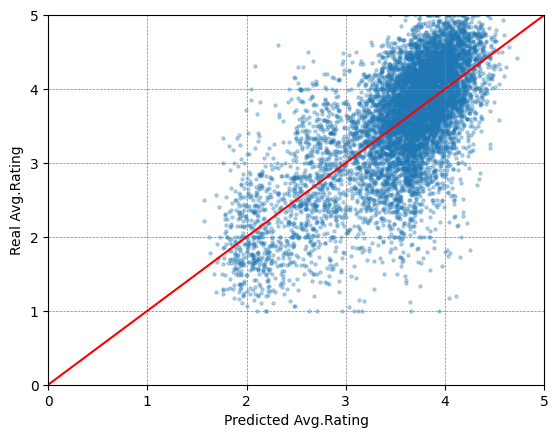

In [60]:
import matplotlib.pyplot as plt

plt.scatter(predictions, y_test, s= 5, alpha=0.3)

x = [0, 5]
y = [0, 5]



plt.plot(x, y, color = "red")

plt.ylabel('Real Avg.Rating')
plt.xlabel('Predicted Avg.Rating')

plt.grid(True, linestyle='--', linewidth=0.5, color='gray')


plt.ylim(0,5)
plt.xlim(0,5)

In [123]:
np.max(ridge_predictions)

4.259749081533041

(0.0, 5.0)

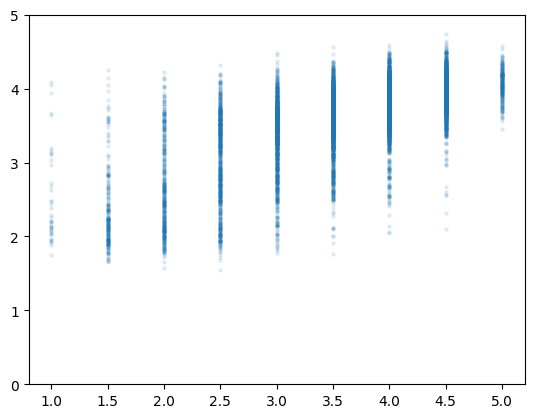

In [124]:
import matplotlib.pyplot as plt

plt.scatter(y_test_real,ridge_predictions, s= 5, alpha=0.1)
plt.ylim(0,5)

In [122]:
brand_counts.to_csv("yelp_brands.csv")